## **Sentiment Analysis Using LSTM (Long Short-Term Memory)**

## **Load Libraries and Dataset**

In [ ]:
pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import nltk
import regex as re
import tensorflow as tf
from nltk.corpus import stopwords as stopword
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data_df = pd.read_csv('train_preprocess.tsv.txt', names = ['Text','Sentiment'], sep = '\t')
data_df.drop_duplicates()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [ ]:
data_df.head()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [ ]:
## One Hot Encoding
category = pd.get_dummies(data_df['Sentiment'])
category.head()

,negative,neutral,positive
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0


In [ ]:
## Concat and remove column sentiment

train_df = pd.concat([data_df,category], axis  =1)
train_df = train_df.drop(columns = 'Sentiment')
train_df.head()

,Text,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,0,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,1,0
2,lokasi strategis di jalan sumatera bandung . t...,0,0,1
3,betapa bahagia nya diri ini saat unboxing pake...,0,0,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,1,0,0


## **Text Cleansing**

In [ ]:
## Dict for Kata Alay
kamusalay_df = pd.read_csv('new_kamusalay.csv', names = ['ALAY', 'TIDAK_ALAY'], encoding = 'latin1')
dict_alay = {
    'ALAY':[],
    'TIDAK_ALAY':[]
}
for i in kamusalay_df.itertuples():
  dict_alay['ALAY'].append(i.ALAY)
  dict_alay['TIDAK_ALAY'].append(i.TIDAK_ALAY)

In [ ]:
## REGEX FUNCTION for Cleansing Text

# 1. remove USER,RT,URL
def remove_user_rt_url (str):
    string = re.sub(r'USER|\bRT\b|URL',' ',str)
    return string

#2 buat lower case
def lower_case (str):
    string = str.lower()
    return string

#3 remove /n
def remove_n (str):
    string =  re.sub(r'\\n',' ',str)
    return string

#4 remove emoji
def remove_emo2 (str):
    pattern = re.compile(r'[\\x]+[a-z0-9]{2}')
    string = re.sub(pattern,'',str)
    return string

#5 Remove Link
# remove link (http|https)
def remove_link (str):
    pattern = re.compile(r'www\S+|http\S+')
    string =  re.sub(pattern,' ',str)
    return string

#6 Remove Special Character
def remove_character(str):
    string = re.sub(r'[^a-zA-Z]+',' ',str)
    return string

#8 repalce alay word
def replace_alay(str):
    for i in range(0,len(kamusalay_df)-1):
        alay = dict_alay['ALAY'][i]
        if (' ' + alay + ' ') in (' ' + str + ' '):
            replace = dict_alay['TIDAK_ALAY'][i]
            str = re.sub(r'\b{}\b'.format(alay),replace,str)
    return str

#9 remove extra space
def remove_extra_space (str):
    str = re.sub('  +', ' ', str)
    str = str.strip()
    return str

def regex_cleansing(str):
    str = remove_user_rt_url (str)
    str = lower_case (str)
    str = remove_n (str)
    str = remove_emo2 (str)
    str = remove_link (str)
    str = remove_character(str)
    str = remove_extra_space (str)
    str = replace_alay(str)
    str = remove_extra_space (str)
    return str

In [ ]:
train_df['Text_Cleansing'] = train_df['Text'].apply(regex_cleansing)
train_df = train_df[['Text','Text_Cleansing','negative','neutral','positive']]

In [ ]:
train_df.head()

,Text,Text_Cleansing,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,0,0,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,0,1,0
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,0,0,1
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,0,0,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,1,0,0


## **Preprocessing Text**

In [ ]:
## Preprocessing Text

factory = StemmerFactory()
stemer = factory.create_stemmer()

list_stopwords_id = stopword.words('indonesian')
list_stopwords_en = stopword.words('english')

list_stopwords_id.extend(list_stopwords_en)
list_stopwords_id.extend(['ya', 'yg', 'ga', 'yuk', 'dah','nya','duh','sih'])

not_stopwords = {'enggak', 'tidak'}
list_stopwords_id = set([word for word in list_stopwords_id if word not in not_stopwords])

#1 Tokenize
def tokenize (text):
  token = word_tokenize(text)
  return token

#2 StopWord removal
def stop_words(text):
  after_stopwords = [word for word in text if not word in list_stopwords_id]
  return after_stopwords

#3 Stemming
def stemming (text):
  after_stemming = [stemer.stem(word) for word in text]
  return after_stemming

#4 Token to sentence
def sentence(list_words):
  sentence = ' '.join(word for word in list_words)
  return sentence


In [ ]:
def preprocesing(text):
  text = tokenize(text)
  text = stop_words(text)
  text = stemming(text)
  text = sentence(text)
  return text

In [ ]:
train_df['Text_Preprocessing'] = train_df['Text_Cleansing'].apply(preprocesing)
train_df = train_df[['Text','Text_Cleansing','Text_Preprocessing','negative','neutral','positive']]

train_df.head()

,Text,Text_Cleansing,Text_Preprocessing,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,0,0,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus k mmbri hujjah partai diwlh ...,0,1,0
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nyaman ...,0,0,1
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,betapa bahagia unbog paket barang bagus tetap ...,0,0,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...,1,0,0


In [ ]:
X = train_df['Text_Preprocessing'].values
y = train_df[['negative','neutral','positive']].values

In [ ]:
## Store data preprocessing to db or use pickle so it will be easier to implement into the API

import pickle

with open('text_preprocessing.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("text_preprocessing.pickle has created!")

text_preprocessing.pickle has created!


In [ ]:
tokenisasi = Tokenizer(num_words = 100000, oov_token = 'OOV')

tokenisasi.fit_on_texts(X)

In [ ]:
def texts_sequences (text):
  sequence = tokenisasi.texts_to_sequences(text)
  return sequence

def pading(sequences):
  pad = pad_sequences(sequences, maxlen = 55)
  return pad

def sequences_padding(text):
  sequences = texts_sequences(text)
  print(sequences)
  pad = pading(sequences)
  return pad

In [ ]:
pad_X_sequences = sequences_padding(X)

## **Train Test Split**

In [ ]:
## Train Split Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pad_X_sequences, y, test_size = 0.1, random_state = 3)

## **Create LSTM Model**

In [ ]:
## LSTM MODEL
model_nlp = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(100000, 100, input_length = pad_X_sequences.shape[1]),
    tf.keras.layers.LSTM(64, dropout = 0.5, return_sequences=True),
    tf.keras.layers.LSTM(32, dropout = 0.5,),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
model_nlp.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.0001),
    loss = 'CategoricalCrossentropy',
    metrics = ['accuracy']
)

In [ ]:
# class CallBack (tf.keras.callbacks.Callback):
#   def on_epoch_end (self, epoch, logs={}):
#     if(logs.get('accuracy') == 1):
#       print('\nAkurasi telah menacapai > 95%')
#       self.model.stop_training = True
# my_callback = CallBack()

In [ ]:
 early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model_nlp.fit(
    X_train,
    y_train,
    epochs = 30,
    batch_size = 64,
 #   callbacks = [my_callback],
    callbacks=[early_stop],
    validation_data = (X_test, y_test),
    verbose = 1
)

Epoch 1/30
155/155 [==============================] - 71s 421ms/step - loss: 0.9723 - accuracy: 0.6040 - val_loss: 0.7816 - val_accuracy: 0.6991
Epoch 2/30
155/155 [==============================] - 64s 411ms/step - loss: 0.7492 - accuracy: 0.6905 - val_loss: 0.6490 - val_accuracy: 0.7436
Epoch 3/30
155/155 [==============================] - 64s 412ms/step - loss: 0.6375 - accuracy: 0.7500 - val_loss: 0.5675 - val_accuracy: 0.7845
Epoch 4/30
155/155 [==============================] - 64s 412ms/step - loss: 0.5678 - accuracy: 0.7721 - val_loss: 0.5114 - val_accuracy: 0.8000
Epoch 5/30
155/155 [==============================] - 64s 413ms/step - loss: 0.5290 - accuracy: 0.7859 - val_loss: 0.4938 - val_accuracy: 0.8100
Epoch 6/30
155/155 [==============================] - 64s 414ms/step - loss: 0.4989 - accuracy: 0.7973 - val_loss: 0.4875 - val_accuracy: 0.8118
Epoch 7/30
155/155 [==============================] - 64s 412ms/step - loss: 0.4730 - accuracy: 0.8047 - val_loss: 0.4700 - val_ac

## **Visualization loss and accuracy model**

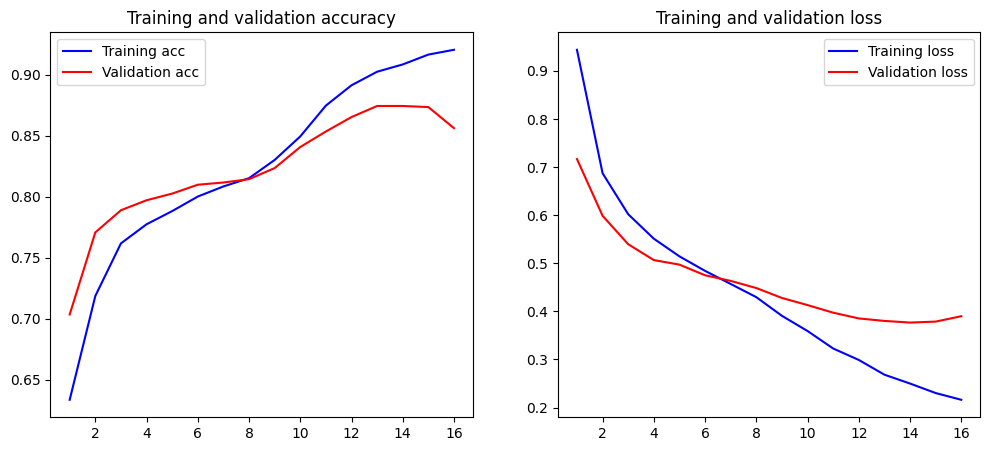

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

## **Cross Validation**

In [ ]:
## Croos Validation


kf = KFold(n_splits=5,random_state=3,shuffle=True)

accuracies = []

label = y


for iteration, data in enumerate(kf.split(pad_X_sequences), start=1):

    data_train   = pad_X_sequences[data[0]]
    target_train = label[data[0]]

    data_test    = pad_X_sequences[data[1]]
    target_test  = label[data[1]]

    model_nlp.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

    history = model_nlp.fit(
    data_train,
    target_train,
    epochs = 30,
    batch_size = 64,
 #   callbacks = [my_callback],
    callbacks=[early_stop],
    validation_data = (data_test, target_test),
    verbose = 1)

    predictions = model_nlp.predict(X_test)
    y_pred = predictions

    # for the current fold only

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print()
    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

   # plot_history(history)

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))

Epoch 1/30
138/138 [==============================] - 61s 412ms/step - loss: 0.2130 - accuracy: 0.9201 - val_loss: 0.2935 - val_accuracy: 0.9032
Epoch 2/30
138/138 [==============================] - 54s 389ms/step - loss: 0.1976 - accuracy: 0.9292 - val_loss: 0.2931 - val_accuracy: 0.9059
Epoch 3/30
138/138 [==============================] - 54s 390ms/step - loss: 0.1903 - accuracy: 0.9309 - val_loss: 0.2941 - val_accuracy: 0.9023
Epoch 4/30
138/138 [==============================] - 54s 388ms/step - loss: 0.1864 - accuracy: 0.9320 - val_loss: 0.2958 - val_accuracy: 0.9009
Epoch 4: early stopping
35/35 [==============================] - 2s 19ms/step

Training ke- 1
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       328
           1       0.83      0.69      0.75       105
           2       0.90      0.94      0.92       667

    accuracy                           0.87      1100
   macro avg       0.85      0.80      0.82      1100


## **Saved Model**

In [ ]:
## Saved Model

model_nlp.save('model_LSTM.h5')
print("Model has created!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


## **Testing Model**

In [ ]:
def predict_sentiment(text):
  text = regex_cleansing(text)
  text = [preprocesing(text)]
  print(text)
  pad = sequences_padding(text)
  predict = model_nlp.predict(pad)
  print(predict)
  for i in predict:
    if i[0] > i[1] and i[0] > i[2]:
      output = 'Negative'
    elif i[1] > i[0] and i[1] > i[2]:
      output = 'Neutral'
    elif i[2] > i[0] and i[2] > i[1]:
      output = 'Positive'
  return output

In [ ]:
## Testing Model

text = 'Saya bangga menjadi warga indonesia'
sentiment = predict_sentiment(text)
print(text)
print('Sentiment ==> ', sentiment)

['bangga warga indonesia']
[[562, 433, 25]]
1/1 [==============================] - 0s 76ms/step
[[0.08571635 0.03637041 0.8779133 ]]
Saya bangga menjadi warga indonesia
Sentiment ==>  Positive


In [ ]:
## Testing Model

text = 'Kamu Sombong dan angkuh, Aku benci sama kamu'
sentiment = predict_sentiment(text)
print(text)
print('Sentiment ==> ', sentiment)

[[1048, 5338, 498]]
1/1 [==============================] - 0s 20ms/step
[[0.546607   0.1703191  0.28307393]]
Kamu Sombong dan angkuh, Aku benci sama kamu
Sentiment ==>  Negative


In [ ]:
## Testing Model With Tweet Dataset

tweet_df = pd.read_csv('tweet_datatest.csv', encoding = 'windows-1250', usecols = [0])
tweet_df.drop_duplicates()

#tweet_df['Tweet_Cleansing'] = tweet_df['Tweet'].apply(regex_cleansing)
#tweet_df['Tweet_Preprocessing'] = tweet_df['Tweet_Cleansing'].apply(preprocesing)

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...
...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...
13165,USER Kasur mana enak kunyuk'
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...
13167,USER USER USER USER Bom yang real mudah terdet...


In [ ]:
tweet_df.loc[64]

Tweet                  Budaya kafir bersungguh, klau hal2 islam tidak...
Tweet_Cleansing        budaya kafir bersungguh kalau hal islam tidak ...
Tweet_Preprocessing                     budaya kafir sungguh islam indah
Name: 64, dtype: object

In [ ]:
tweet_df['Sentiment_Tweet'] = tweet_df['Tweet'].apply(predict_sentiment)

In [ ]:
tweet_df.head()

# Negative = 10365
# Positive = 922
# Neutral = 1882

,Tweet,Sentiment_Tweet
0,- disaat semua cowok berusaha melacak perhatia...,Negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,Positive
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",Positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,Positive
4,USER USER Kaum cebong kapir udah keliatan dong...,Negative


In [ ]:
tweet_df[tweet_df['Sentiment_Tweet'] == 'Negative']

,Tweet,Sentiment_Tweet
0,- disaat semua cowok berusaha melacak perhatia...,Negative
4,USER USER Kaum cebong kapir udah keliatan dong...,Negative
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,Negative
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,Negative
9,USER Enak lg klo smbil ngewe',Negative
...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,Negative
13165,USER Kasur mana enak kunyuk',Negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,Negative
13167,USER USER USER USER Bom yang real mudah terdet...,Negative


In [ ]:
tweet_df[tweet_df['Sentiment_Tweet'] == 'Positive']

,Tweet,Sentiment_Tweet
1,RT USER: USER siapa yang telat ngasih tau elu?...,Positive
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",Positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,Positive
27,menurutku pintu sorga ada yaitu pintu sorga ya...,Positive
38,USER USER Presiden RI Jokowi luarBiasa kerja n...,Positive
...,...,...
13150,USER Tambahan : \nArsitektur Universitas Katol...,Positive
13158,Maaf sianu mah cocoknya sama mustafa kemal alm...,Positive
13159,Ada 2 buku aktivitas Angry Birds the Movie yan...,Positive
13160,[NOSTALGIA DENGAN BUDAYA]; ; nosÂ·talÂ·gia n k...,Positive


In [ ]:
tweet_df[tweet_df['Sentiment_Tweet'] == 'Neutral']

,Tweet,Sentiment_Tweet
6,deklarasi pilkada 2018 aman dan anti hoax warg...,Neutral
8,Nah admin belanja satu lagi port terbaik nak m...,Neutral
23,PELAJAR SMA KEC BILAH HILIR DEKLARASI ANTI HOA...,Neutral
24,Bandara Udara Internasional Kertajati dibangun...,Neutral
28,RT USER USER USER PKI hanya muncul jika jelang...,Neutral
...,...,...
13110,Ketahanan ideologi &amp; mental menjadi masala...,Neutral
13113,"Survei Penyusunan Disagregasi PMTB, BPS Kota S...",Neutral
13116,USER Rezim kemarin saya dan keluarga pilih dem...,Neutral
13123,"Pilkada Serentak 2018, Sumut Jadi Contoh Demok...",Neutral
